Working with the med3pa Subpackage
-----------------------------------------

This tutorial guides you through the process of setting up and running comprehensive experiments using the `med3pa` subpackage. It includes steps to execute MED3pa experiment with `Med3paExperiment` and the combination of MED3pa and Detectron using `Med3paDetectronExperiment`.


## Running the MED3pa Experiment


### Step 1: Setting up the Datasets
First, configure the `DatasetsManager`. In the case of MED3pa only experiment you only need to set the DatasetManager with either `testing` and `reference` dataset:


In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from MED3pa.datasets import DatasetsManager

# Initialize the DatasetsManager
datasets = DatasetsManager()

# Load datasets for reference, and testing
datasets.set_from_file(dataset_type="training", file='./data/train_data.csv', target_column_name='Outcome')
datasets.set_from_file(dataset_type="validation", file='./data/val_data.csv', target_column_name='Outcome')
datasets.set_from_file(dataset_type="reference", file='./data/test_data.csv', target_column_name='Outcome')
datasets.set_from_file(dataset_type="testing", file='./data/test_data.csv', target_column_name='Outcome')


# Initialize the DatasetsManager
datasets2 = DatasetsManager()

# Load datasets for reference, and testing
datasets2.set_from_file(dataset_type="training", file='./data/train_data.csv', target_column_name='Outcome')
datasets2.set_from_file(dataset_type="validation", file='./data/val_data.csv', target_column_name='Outcome')
datasets2.set_from_file(dataset_type="reference", file='./data/test_data.csv', target_column_name='Outcome')
datasets2.set_from_file(dataset_type="testing", file='./data/test_data.csv', target_column_name='Outcome')


## Step 2: Configuring the Model
Next, utilize the `ModelFactory` to load a pre-trained model, and set it as the base model for the experiment. Alternatively, you can train your own model and use it:


In [2]:
from MED3pa.models import BaseModelManager, ModelFactory

# Initialize the model factory and load the pre-trained model
factory = ModelFactory()
model = factory.create_model_from_pickled("./models/diabetes_xgb_model.pkl")
model2 = factory.create_model_from_pickled("./models/diabetes_xgb_model_2.pkl")



## Step 3: Running the MED3pa Experiment
Execute the MED3PA experiment with the specified datasets and base model. You can also specify other parameters as needed. See the documentation of the subpackage for more information about the parameters.

The experiment outputs two structure one for the reference set and the other for the testing set, both containing files indicating the extracted profiles at different declaration rates, the performance of the model on these profiles..etc.


In [3]:
from MED3pa.med3pa import Med3paExperiment, Med3paDetectronExperiment
from MED3pa.med3pa.uncertainty import AbsoluteError
from MED3pa.models import BaseModelManager, ModelFactory

# Define parameters for the experiment
ipc_params = {'n_estimators': 100}
apc_params = {'max_depth': 3}

BaseModelManager.reset()
base_model_manager = BaseModelManager()
base_model_manager.set_base_model(model=model)

# Execute the MED3PA experiment
results1= Med3paExperiment.run(
                                datasets_manager=datasets,
                                base_model_manager=base_model_manager,
                                uncertainty_metric="absolute_error",
                                ipc_type='RandomForestRegressor',
                                ipc_params=ipc_params,
                                apc_params=apc_params,
                                pretrained_ipc='./med3pa_experiment_results_comp2_models/ipc_model.pkl',
                                pretrained_apc='./med3pa_experiment_results_comp2_models/apc_model.pkl',
                                samples_ratio_min=0,
                                samples_ratio_max=10,
                                samples_ratio_step=5,
                                models_metrics=['MSE', 'RMSE'],
                                evaluate_models=True,
                                mode='mpc')

ins1 = base_model_manager.get_instance()
BaseModelManager.reset()

base_model_manager = BaseModelManager()
model2 = factory.create_model_from_pickled("./models/diabetes_xgb_model_2.pkl")
base_model_manager.set_base_model(model=model2)
ins2 = base_model_manager.get_instance()
print(ins1==ins2)
results2= Med3paExperiment.run(
                                datasets_manager=datasets2,
                                base_model_manager=base_model_manager,
                                uncertainty_metric="absolute_error",
                                ipc_type='RandomForestRegressor',
                                ipc_params=ipc_params,
                                apc_params=apc_params,
                                pretrained_ipc='./med3pa_experiment_results_comp2_models/ipc_model.pkl', 
                                pretrained_apc='./med3pa_experiment_results_comp2_models/apc_model.pkl',
                                samples_ratio_min=0,
                                samples_ratio_max=10,
                                samples_ratio_step=5,
                                models_metrics=['MSE', 'RMSE'],
                                evaluate_models=True,
                                mode='mpc')


Running MED3pa Experiment on the reference set:
Loaded a pretrained IPC model.
Individualized confidence scores calculated.
Loaded a pretrained APC model.
Aggregated confidence scores calculated.
Mixed confidence scores calculated.
Results extracted for minimum_samples_ratio =  0
Results extracted for minimum_samples_ratio =  5
Results extracted for minimum_samples_ratio =  10
Running MED3pa Experiment on the test set:
Loaded a pretrained IPC model.
Individualized confidence scores calculated.
Loaded a pretrained APC model.
Aggregated confidence scores calculated.
Mixed confidence scores calculated.
Results extracted for minimum_samples_ratio =  0
Results extracted for minimum_samples_ratio =  5
Results extracted for minimum_samples_ratio =  10
False
Running MED3pa Experiment on the reference set:
Loaded a pretrained IPC model.
Individualized confidence scores calculated.
Loaded a pretrained APC model.
Aggregated confidence scores calculated.
Mixed confidence scores calculated.
Results

## Step 4: Analyzing and Saving the Results
After running the experiment, you can analyze and save the results using the returned `Med3paResults` instance:


In [4]:
# Save the results to a specified directory
results1.save(file_path='./med3pa_experiment_results_comp1')
results2.save(file_path='./med3pa_experiment_results_comp2')



In [5]:
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from MED3pa.med3pa.comparaison import Med3paComparison

comparaison = Med3paComparison('./med3pa_experiment_results_comp1', './med3pa_experiment_results_comp2')
comparaison.compare_experiments()
comparaison.save('./med3pa_comparaison_results')

In [6]:
import matplotlib.pyplot as plt
import os
import json 

results1_json_path = os.path.join('./med3pa_experiment_results_comp1', 'test', 'metrics_dr.json')
results2_json_path = os.path.join('./med3pa_experiment_results_comp2', 'test', 'metrics_dr.json')

with open(results1_json_path, 'r') as f1, open(results2_json_path, 'r') as f2:
    json1 = json.load(f1)
    json2 = json.load(f2)

keys = sorted(json1.keys(), key=int, reverse=True)
auc_values1 = [json1[key]["metrics"]["Accuracy"] for key in keys]
auc_values2 = [json2[key]["metrics"]["Accuracy"] for key in keys]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(keys, auc_values1, label='Model 1')
plt.plot(keys, auc_values2, label='Model 2')
plt.xlabel('DR')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.grid(True)

# Set x-ticks to steps of 10
plt.xticks(ticks=[str(i) for i in range(100, -1, -10)])


plt.show()

ImportError: DLL load failed while importing _imaging: The specified module could not be found.

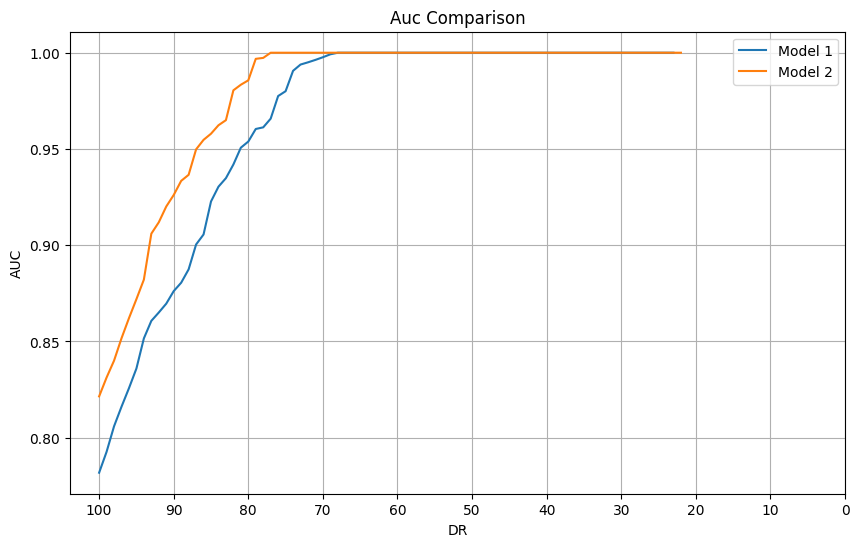

In [ ]:
keys = sorted(json1.keys(), key=int, reverse=True)
auc_values1 = [json1[key]["metrics"]["Auc"] for key in keys]
auc_values2 = [json2[key]["metrics"]["Auc"] for key in keys]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(keys, auc_values1, label='Model 1')
plt.plot(keys, auc_values2, label='Model 2')
plt.xlabel('DR')
plt.ylabel('AUC')
plt.title('Auc Comparison')
plt.legend()
plt.grid(True)

# Set x-ticks to steps of 10

plt.xticks(ticks=[str(i) for i in range(100, -1, -10)])

plt.show()

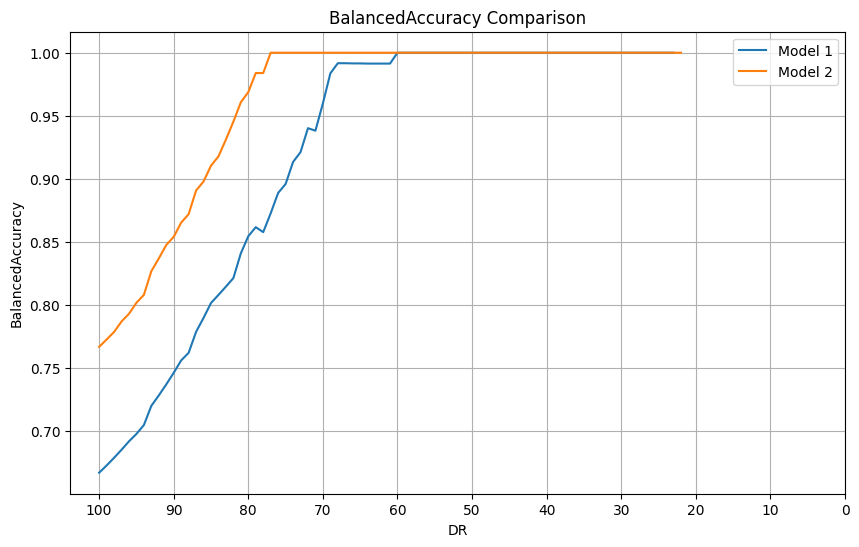

In [ ]:
keys = sorted(json1.keys(), key=int, reverse=True)
auc_values1 = [json1[key]["metrics"]["BalancedAccuracy"] for key in keys]
auc_values2 = [json2[key]["metrics"]["BalancedAccuracy"] for key in keys]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(keys, auc_values1, label='Model 1')
plt.plot(keys, auc_values2, label='Model 2')
plt.xlabel('DR')
plt.ylabel('BalancedAccuracy')
plt.title('BalancedAccuracy Comparison')
plt.legend()
plt.grid(True)

# Set x-ticks to steps of 10
plt.xticks(ticks=[str(i) for i in range(100, -1, -10)])

plt.show()

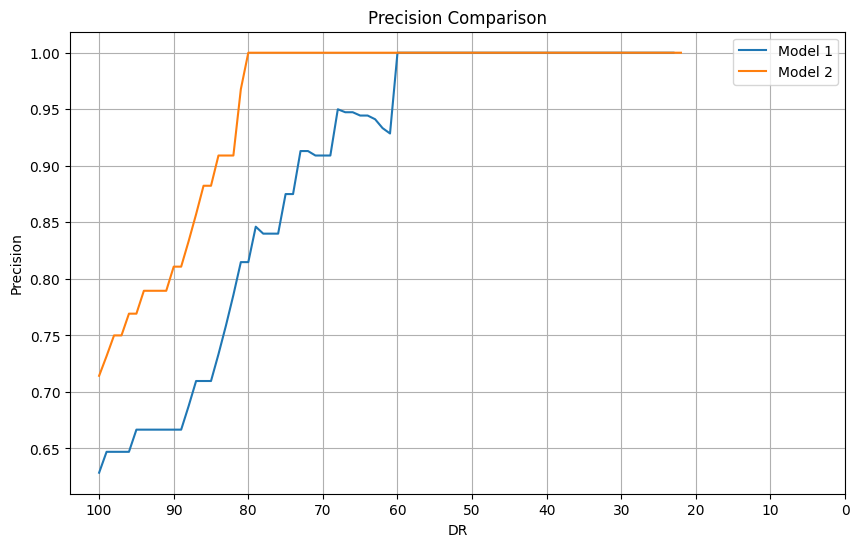

In [ ]:
keys = sorted(json1.keys(), key=int, reverse=True)
auc_values1 = [json1[key]["metrics"]["Precision"] for key in keys]
auc_values2 = [json2[key]["metrics"]["Precision"] for key in keys]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(keys, auc_values1, label='Model 1')
plt.plot(keys, auc_values2, label='Model 2')
plt.xlabel('DR')
plt.ylabel('Precision')
plt.title('Precision Comparison')
plt.legend()
plt.grid(True)

# Set x-ticks to steps of 10
plt.xticks(ticks=[str(i) for i in range(100, -1, -10)])

plt.show()

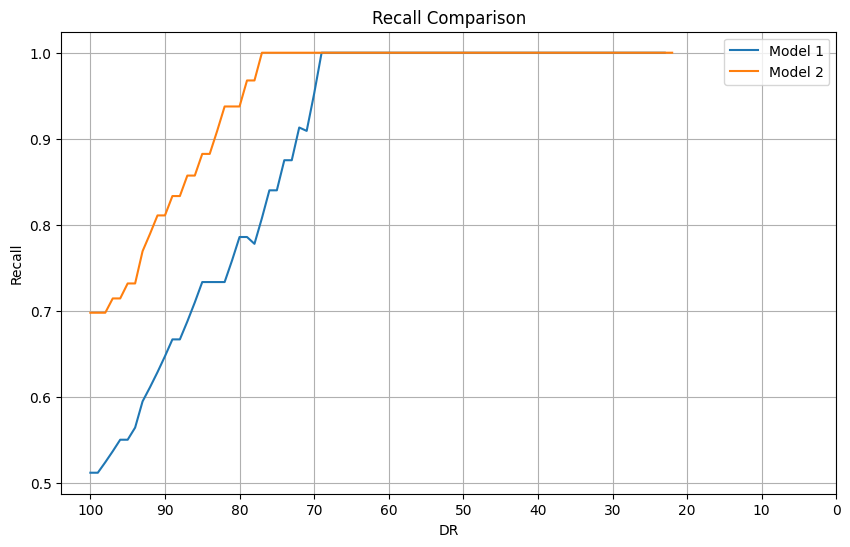

In [ ]:
keys = sorted(json1.keys(), key=int, reverse=True)
auc_values1 = [json1[key]["metrics"]["Recall"] for key in keys]
auc_values2 = [json2[key]["metrics"]["Recall"] for key in keys]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(keys, auc_values1, label='Model 1')
plt.plot(keys, auc_values2, label='Model 2')
plt.xlabel('DR')
plt.ylabel('Recall')
plt.title('Recall Comparison')
plt.legend()
plt.grid(True)

# Set x-ticks to steps of 10
plt.xticks(ticks=[str(i) for i in range(100, -1, -10)])

plt.show()

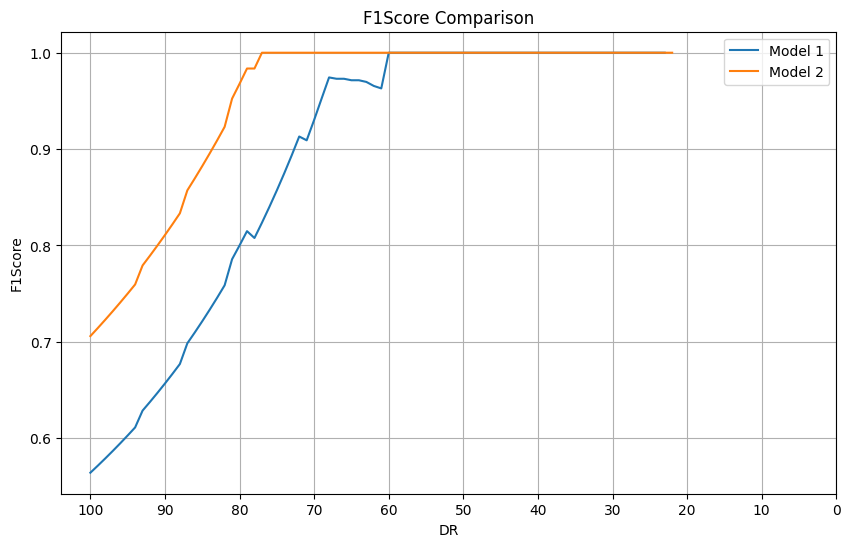

In [ ]:
keys = sorted(json1.keys(), key=int, reverse=True)
auc_values1 = [json1[key]["metrics"]["F1Score"] for key in keys]
auc_values2 = [json2[key]["metrics"]["F1Score"] for key in keys]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(keys, auc_values1, label='Model 1')
plt.plot(keys, auc_values2, label='Model 2')
plt.xlabel('DR')
plt.ylabel('F1Score')
plt.title('F1Score Comparison')
plt.legend()
plt.grid(True)

# Set x-ticks to steps of 10
plt.xticks(ticks=[str(i) for i in range(100, -1, -10)])

plt.show()

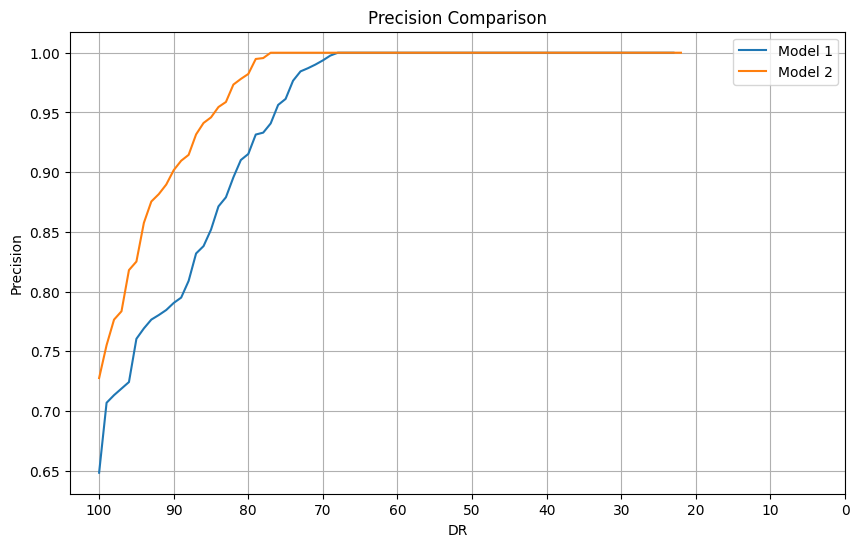

In [ ]:
keys = sorted(json1.keys(), key=int, reverse=True)
auc_values1 = [json1[key]["metrics"]["Auprc"] for key in keys]
auc_values2 = [json2[key]["metrics"]["Auprc"] for key in keys]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(keys, auc_values1, label='Model 1')
plt.plot(keys, auc_values2, label='Model 2')
plt.xlabel('DR')
plt.ylabel('Precision')
plt.title('Precision Comparison')
plt.legend()
plt.grid(True)

# Set x-ticks to steps of 10
plt.xticks(ticks=[str(i) for i in range(100, -1, -10)])

plt.show()

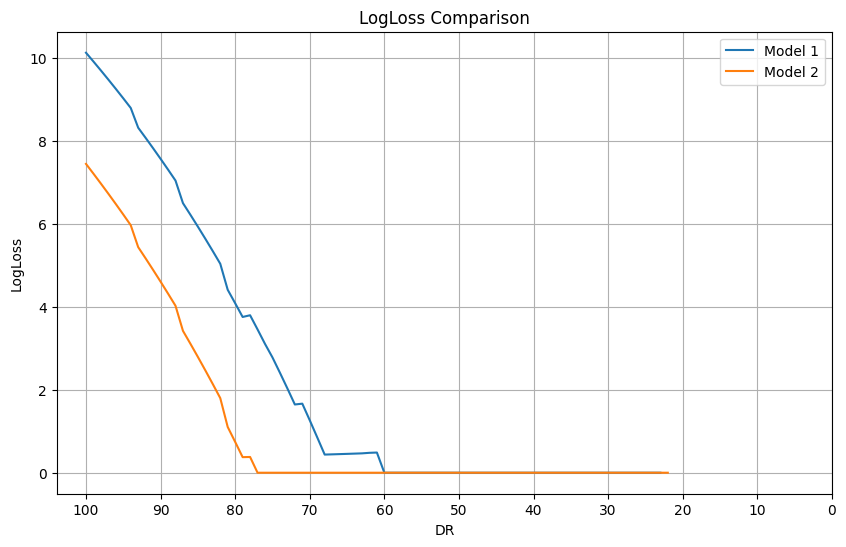

In [ ]:
keys = sorted(json1.keys(), key=int, reverse=True)
auc_values1 = [json1[key]["metrics"]["LogLoss"] for key in keys]
auc_values2 = [json2[key]["metrics"]["LogLoss"] for key in keys]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(keys, auc_values1, label='Model 1')
plt.plot(keys, auc_values2, label='Model 2')
plt.xlabel('DR')
plt.ylabel('LogLoss')
plt.title('LogLoss Comparison')
plt.legend()
plt.grid(True)

# Set x-ticks to steps of 10
plt.xticks(ticks=[str(i) for i in range(100, -1, -10)])

plt.show()

In [ ]:
import pandas as pd

results1_json_path = os.path.join('./med3pa_experiment_results_comp1', 'test', 'profiles.json')
results2_json_path = os.path.join('./med3pa_experiment_results_comp2', 'test', 'profiles.json')

with open(results1_json_path, 'r') as f1, open(results2_json_path, 'r') as f2:
    json1 = json.load(f1)
    json2 = json.load(f2)

# Function to extract profiles at dr 100 for a given structure
def extract_profiles_at_dr_100(structure):
    profiles = {}
    for samples_ratio, drs in structure.items():
        if "100" in drs:
            profiles[samples_ratio] = {profile['id']: profile for profile in drs["100"]}
    return profiles

# Function to get metrics for all drs for a given profile id
def get_metrics_for_profile(structure, profile_id, samples_ratio):
    drs_metrics = {}
    for dr, profiles in structure[samples_ratio].items():
        profile = next((p for p in profiles if p['id'] == profile_id), None)
        drs_metrics[dr] = profile['metrics'] if profile else None
    return drs_metrics

# Extract profiles at dr 100
profiles_1 = extract_profiles_at_dr_100(json1)
profiles_2 = extract_profiles_at_dr_100(json1)

# Function to get all metrics for all drs
def get_all_metrics(structure, profiles, samples_ratio):
    all_metrics = {}
    for profile_id in profiles:
        all_metrics[profile_id] = get_metrics_for_profile(structure, profile_id, samples_ratio)
    return all_metrics

# Compare metrics for each samples_ratio
comparison_results = {}
for samples_ratio in profiles_1:
    if samples_ratio in profiles_2:
        metrics_1 = get_all_metrics(json1, profiles_1[samples_ratio], samples_ratio)
        metrics_2 = get_all_metrics(json1, profiles_2[samples_ratio], samples_ratio)
        
        for profile_id in metrics_1:
            if profile_id in metrics_2:
                for dr in metrics_1[profile_id]:
                    if dr not in comparison_results:
                        comparison_results[profile_id] = {}
                    if samples_ratio not in comparison_results[profile_id]:
                        comparison_results[profile_id][samples_ratio] = {}
                    if dr not in comparison_results[profile_id][samples_ratio]:
                        comparison_results[profile_id][samples_ratio][dr] = {}
                        
                    comparison_results[profile_id][samples_ratio][dr]['structure_1'] = metrics_1[profile_id][dr]
                    comparison_results[profile_id][samples_ratio][dr]['structure_2'] = metrics_2[profile_id][dr]

# Save results to JSON file
with open('comparison_results.json', 'w') as json_file:
    json.dump(comparison_results, json_file, indent=4)

print("Comparison results saved to 'comparison_results.json'.")

Comparison results saved to 'comparison_results.json'.


In [ ]:
def extract_profiles_with_path_and_samples_ratio(structure):
    profiles = {}
    for samples_ratio, dr_dict in structure.items():
        if samples_ratio not in profiles:
            profiles[samples_ratio] = {}
        for dr, profile_list in dr_dict.items():
            for profile in profile_list:
                profile_path = " / ".join(profile["path"])  # Convert path to string
                if profile_path not in profiles[samples_ratio]:
                    profiles[samples_ratio][profile_path] = {}
                profiles[samples_ratio][profile_path][dr] = profile["metrics"]
    return profiles

# Extract profiles from both structures using path and samples_ratio as keys
profiles_1 = extract_profiles_with_path_and_samples_ratio(json1)
profiles_2 = extract_profiles_with_path_and_samples_ratio(json2)

# Combine profiles from both structures using path and samples_ratio as keys
combined_profiles = {}
for samples_ratio in set(profiles_1.keys()).union(profiles_2.keys()):
    combined_profiles[samples_ratio] = {}
    paths = set(profiles_1.get(samples_ratio, {}).keys()).union(profiles_2.get(samples_ratio, {}).keys())
    for profile_path in paths:
        combined_profiles[samples_ratio][profile_path] = {}
        for dr in range(100, -1, -1):
            dr_str = str(dr)
            metrics_1 = profiles_1.get(samples_ratio, {}).get(profile_path, {}).get(dr_str)
            metrics_2 = profiles_2.get(samples_ratio, {}).get(profile_path, {}).get(dr_str)
            combined_profiles[samples_ratio][profile_path][dr_str] = {
                "metrics_1": metrics_1,
                "metrics_2": metrics_2
            }

# Convert tuple keys to strings for JSON serialization
combined_profiles_str_keys = {samples_ratio: 
                              {str(profile_path): metrics for profile_path, metrics in profiles.items()} 
                              for samples_ratio, profiles in combined_profiles.items()}

# Save the combined profiles to a JSON file
output_file_path = "./combined_profiles.json"
with open(output_file_path, "w") as f:
    json.dump(combined_profiles_str_keys, f, indent=4)

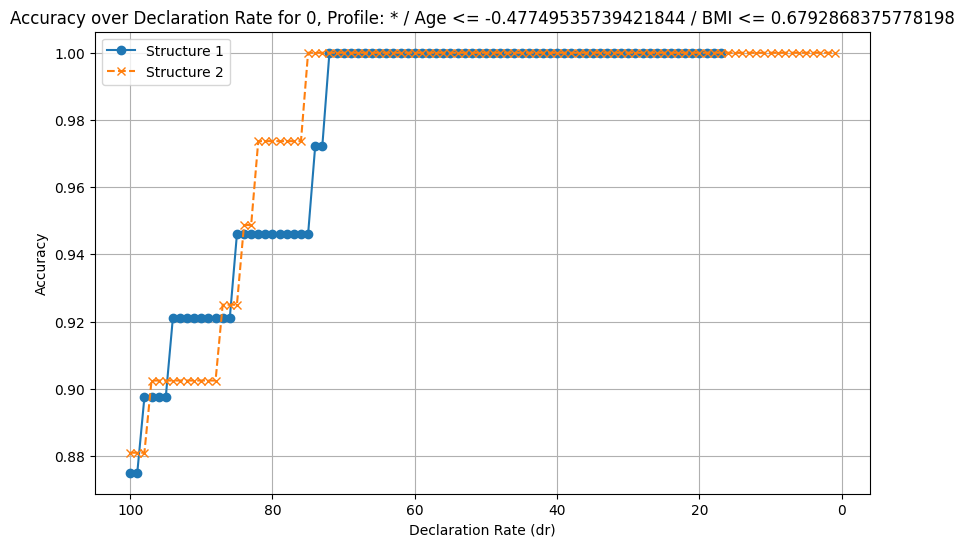

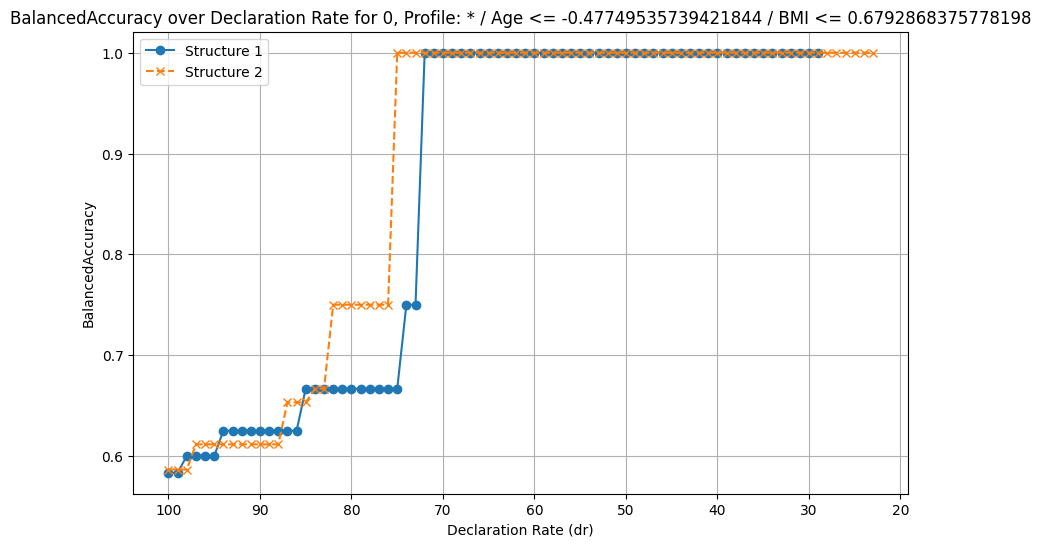

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics_curves(samples_ratio, metrics_list, combined_profiles, profile_path):
    """
    Plots the curves of specified metrics for a specific profile in structure 1 and 2.

    Parameters:
    samples_ratio (str): The samples_ratio to plot.
    metrics_list (list): The list of metrics to plot.
    combined_profiles (dict): The combined profiles dictionary.
    profile_path (str): The path of the profile to plot.
    """
    if samples_ratio not in combined_profiles:
        print(f"Samples ratio '{samples_ratio}' not found in combined profiles.")
        return
    
    profiles = combined_profiles[samples_ratio]
    
    if profile_path not in profiles:
        print(f"Profile path '{profile_path}' not found in samples ratio '{samples_ratio}'.")
        return

    dr_dict = profiles[profile_path]
    drs = sorted(dr_dict.keys(), key=int, reverse=True)  # Sort in descending order
    
    for metric in metrics_list:
        metrics_1 = [dr_dict[dr]['metrics_1'].get(metric) for dr in drs if dr_dict[dr]['metrics_1'] and dr_dict[dr]['metrics_1'].get(metric) is not None]
        metrics_2 = [dr_dict[dr]['metrics_2'].get(metric) for dr in drs if dr_dict[dr]['metrics_2'] and dr_dict[dr]['metrics_2'].get(metric) is not None]
        drs_filtered_1 = [int(dr) for dr in drs if dr_dict[dr]['metrics_1'] and dr_dict[dr]['metrics_1'].get(metric) is not None]
        drs_filtered_2 = [int(dr) for dr in drs if dr_dict[dr]['metrics_2'] and dr_dict[dr]['metrics_2'].get(metric) is not None]
        
        plt.figure(figsize=(10, 6))
        if metrics_1:
            plt.plot(drs_filtered_1, metrics_1, label='Structure 1', linestyle='-', marker='o')
        if metrics_2:
            plt.plot(drs_filtered_2, metrics_2, label='Structure 2', linestyle='--', marker='x')
        
        plt.xlabel('Declaration Rate (dr)')
        plt.ylabel(metric)
        plt.title(f'{metric} over Declaration Rate for {samples_ratio}, Profile: {profile_path}')
        plt.legend()
        plt.grid(True)
        plt.gca().invert_xaxis()  # Invert x-axis to have 100 on the left and 0 on the right
        plt.show()

# Example usage
samples_ratio_example = "samples_ratio_1"
metrics_list_example = ["Accuracy", "BalancedAccuracy"]
profile_path_example = "* / Age <= -0.47749535739421844 / BMI <= 0.6792868375778198"
plot_metrics_curves("0", metrics_list_example, combined_profiles, profile_path_example)
